# 1. Business Problem
## 1.1 Problem Context
Our client is an online retailer based in the UK. They sell all-occasion gifts, and many of their customers are wholesalers.
* Most of their customers are from the UK, but they have a small percent of customers from other countries.
* They want to create groups of these international customers based on their previous purchase patterns.
* Their goal is to provide more tailored services and improve the way they market to these international customers.

## 1.2 Problems with current approach
Currently, the retailer simply groups their international customers by country. As you'll see in the project, this is quite inefficient because:
* There's a large number of countries (which kind of defeats the purpose of creating groups).
* Some countries have very few customers.
* This approach treats large and small customers the same, regardless of their purchase patterns.

## 1.3 Problem Statement
The retailer has hired us to help them create customer clusters, a.k.a **"customer segments"** through a data-driven approach.
* They've provided us a dataset of past purchase data at the transaction level.
* Our task is to build a clustering model using that dataset.
* Our clustering model should factor in both aggregate sales patterns and specific items purchased.

## 1.4 Business Objectives and constraints

# 2. Machine Learning Problem
## 2.1 Data Overview
For this project:
* The dataset has 35116 observations for previous international transactions.
* The observations span 37 different countries.
* **Note:** There is no target variable.

We have the following features:

Invoice information
* 'InvoiceNo' – Unique ID for invoice
* 'InvoiceDate' – Invoice date

Item information
* 'StockCode' – Unique ID for item
* 'Description' – Text description for item
* 'Quantity' – Units per pack for item
* 'UnitPrice' – Price per unit in GBP

Customer information
* 'CustomerID' – Unique ID for customer
* 'Country' – Country of customer

## 2.2 Mapping Buisness problem to ML problem
### 2.2.1 Type of ML Problem
It is an unsupervised learning task, where given the features about each transaction, we need to segment the customers based on their buying patterns.
* It is importnat to note that the given data is transaction-level while the clusters (or segmenst) we need to create are customer-level.

# 3. Exploratory Data Analysis
Import the libraries

In [1]:
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_columns', 100)

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline 

# Seaborn for easier visualization
import seaborn as sns

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# StandardScaler from Scikit-Learn
from sklearn.preprocessing import StandardScaler

# PCA from Scikit-Learn
from sklearn.decomposition import PCA

# Scikit-Learn's KMeans algorithm
from sklearn.cluster import KMeans

# Adjusted Rand index
from sklearn.metrics import adjusted_rand_score

## 3.1 Load the dataset

In [3]:
# Load international online transactions data from CSV
df = pd.read_csv("C:/Users/Asus/Downloads/customer segmentation/int_online_tx.csv")

In [4]:
#Dataframe dimension
df.shape

(35116, 8)

In [5]:
# First 10 rows of data
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,12/1/10 8:45,3.75,12583.0,France
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,12/1/10 8:45,3.75,12583.0,France
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,12/1/10 8:45,3.75,12583.0,France
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,12/1/10 8:45,0.85,12583.0,France
4,536370,21883,STARS GIFT TAPE,24,12/1/10 8:45,0.65,12583.0,France
5,536370,10002,INFLATABLE POLITICAL GLOBE,48,12/1/10 8:45,0.85,12583.0,France
6,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,24,12/1/10 8:45,1.25,12583.0,France
7,536370,21035,SET/2 RED RETROSPOT TEA TOWELS,18,12/1/10 8:45,2.95,12583.0,France
8,536370,22326,ROUND SNACK BOXES SET OF4 WOODLAND,24,12/1/10 8:45,2.95,12583.0,France
9,536370,22629,SPACEBOY LUNCH BOX,24,12/1/10 8:45,1.95,12583.0,France


Here are some questions to consider:
* In the first 10 observations, how many different customers are there?
* How many different invoices are there?
* Given answers to the first two questions, how many unique purchases are shown?
* Technically, aren't these observations actually line-items within each transaction? 
* Do you expect the customer-level dataset to be much smaller?

Display the distribution of transactions by country.

<Axes: xlabel='count', ylabel='Country'>

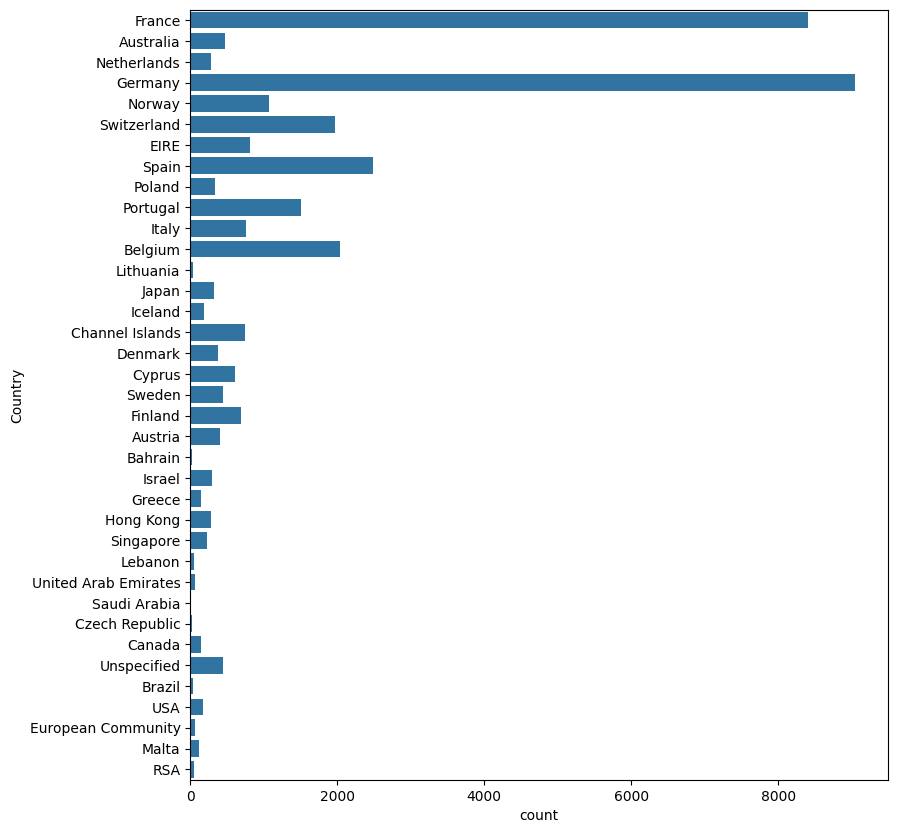

In [6]:
# Make figsize
plt.figure(figsize=(9,10))

# Bar plot by country
sns.countplot(y='Country', data=df)

There are many **sparse classes**. Countries like Lithuania, Brazil, and even the USA have a tiny number of transactions.

**Note:** This is at the transaction/line-item level. The number of customers for each country is even smaller because each customer has multiple transactions! Therefore, it's plain to see that clustering by country is not very efficient.

# 4. Transaction-level Cleaning
Before we aggregate to the customer level, we need to tidy up a few things at the transaction level.
* Technically, this is the **"line-item" level** because one invoice (a.k.a. transaction) spans multiple rows. However, we'll just refer to it as the "transaction level" for simplicity.
* Also the terms **"aggegrating up"** and **"rolling up"** are used interchangeability.

First, we need to check for any missing data before rolling up. If we don't, we might get confusing results later because rolling up to a higher level can sometimes hide the fact that data was missing at the lower level.

Display the number of missing observations for each feature.

In [7]:
# Missing data by feature
df.isnull().sum()

InvoiceNo         0
StockCode         0
Description       0
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID     1418
Country           0
dtype: int64

'CustomerID' has missing observations
* Should we **label them as missing** (as for categorical features) or should we **flag and fill** them (as for numeric features)?
* We should do neither. Instead, we simply need to drop transactions with missing CustomerID.
* Think back to the project scope: We are trying to cluster customers in order to provide more tailored service!
* That means transactions with missing 'CustomerID' are actually pointless to keep.
* In other words, they should be considered "unwanted observations" instead of "missing data!".

Drop observations with missing customer ID's.

In [8]:
# Only keep transactions with CustomerID's
df = df[df.CustomerID.notnull()]

Next, just for clarity, convert the CustomerID's from floats into integers. (This is technically not required, but it's good practice to save ID's as either strings or integers so they don't get mixed up with other numeric features.)

In [9]:
# Convert customer ID's into integers
df['CustomerID'] = df.CustomerID.astype(int)

# Display first 5 CustomerID's in the transaction dataset
df.CustomerID.head()

0    12583
1    12583
2    12583
3    12583
4    12583
Name: CustomerID, dtype: int64

There's one feature we need to create at the transaction level.

Look back at the first 10 observations you displayed earlier.
* Are there any features that tell you how much money the customer spent on each transaction?
* Well, we have 'Quantity' and 'UnitPrice', but those are for individual units, not for the transaction.
* We need to multiply them together to get the Sales amount for that transaction.

In [10]:
# Create 'Sales' interaction feature
df['Sales'] = df.Quantity * df.UnitPrice

# Display first 5 Sales values in the transaction dataset
df.Sales.head()

0    90.0
1    90.0
2    45.0
3    10.2
4    15.6
Name: Sales, dtype: float64

Before moving on, save your cleaned transaction-level data as **cleaned_transactions.csv.**

In [11]:
# Save cleaned transaction-level data
df.to_csv('Files/cleaned_transactions.csv', index=None)

# 5. Customer-level feature engineering
Now that we have a cleaned transaction-level dataset, it's time to **roll it up** (aggregate up) to the customer level, which we'll feed into our machine learning algorithms later.

We want 1 customer per row, and we want the features to represent information such as:
* Number of unique purchases by the customer
* Average cart value for the customer
* Total sales for the customer
* Etc.

To do so, we'll use two tools seen already:
* groupby() to roll up by customer.
* agg() to engineer aggregated features.

Aggegrate invoice data by customer. We'll engineer 1 feature:
* 'total_transactions' - the total number of unique transactions for each customer.

In [13]:
# Aggegrate invoice data
invoice_data = df.groupby('CustomerID').agg(
    total_transactions = ('InvoiceNo', 'nunique')
)

# Display invoice data for first 5 customers
invoice_data.head()

,total_transactions
CustomerID,
12347,7
12348,4
12349,1
12350,1
12352,8


In [15]:
# Aggregate product data
product_data = df.groupby('CustomerID').agg(
    total_products=('StockCode', 'count'),
    total_unique_products=('StockCode', 'nunique')
)

# Display product data for first 5 customers
product_data.head()

,total_products,total_unique_products
CustomerID,,
12347,182,103
12348,31,22
12349,73,73
12350,17,17
12352,85,59


By definition, 'total_unique_products' should always be less than or equal to 'total_products'.

Finally, aggregate sales data by customer. Engineer 2 features:
* 'total_sales' - the total sales for each customer.
* 'avg_product_value' - the average value of the products purchased by the customer (not the UnitPrice!).

In [17]:
# Roll up sales data
sales_data = df.groupby('CustomerID').agg(
    total_sales=('Sales', 'sum'),
    avg_product_value=('Sales', 'mean')
)

# Display sales data for first 5 customers
sales_data.head()

,total_sales,avg_product_value
CustomerID,,
12347,4310.00,23.681319
12348,1797.24,57.975484
12349,1757.55,24.076027
12350,334.40,19.670588
12352,2506.04,29.482824


# 6. Intermediary levels
You won't always be able to easily roll up to customer-level directly. Sometimes, it will be easier to create intermediary levels first.

For example, let's say we wanted to calculate the average cart value for each customer.
* 'avg_product_value' isn't the same thing because it doesn't first group products that were purchased within the same "cart" (i.e. invoice).

Therefore, let's first aggregate cart data at the "cart-level."
* We'll group by 'CustomerID' AND by 'InvoiceID'. Remember, we're treating each invoice as a "cart."
* Then, we'll calculate 'cart_value' by taking the sum of the Sales column. This is the total sales by invoice (i.e. cart).
* Finally, we'll call .reset_index() to turn CustomerID and InvoiceID back into regular columns so we can perform another aggregation.

In [19]:
# Aggregate cart-level data (i.e. invoice-level)
cart_data = df.groupby(['CustomerID', 'InvoiceNo']).agg(
    cart_value=('Sales', 'sum')
)
# Display cart data for first 20 CARTS
cart_data.head(20)

cart_value
CustomerID InvoiceNo            
12347      537626         711.79
           542237         475.39
           549222         636.25
           556201         382.52
           562032         584.91
           573511        1294.32
           581180         224.82
12348      539318         892.80
           541998         227.44
           548955         367.00
           568172         310.00
12349      577609        1757.55
12350      543037         334.40
12352      544156         296.50
           545323         144.35
           545332         840.30
           546869         120.33
           547390         160.33
           567505         366.25
           568699         266.25

In [20]:
# Reset index
cart_data.reset_index(inplace=True)

# Display cart data for first 10 CARTS
cart_data.head(10)

,CustomerID,InvoiceNo,cart_value
0,12347,537626,711.79
1,12347,542237,475.39
2,12347,549222,636.25
3,12347,556201,382.52
4,12347,562032,584.91
5,12347,573511,1294.32
6,12347,581180,224.82
7,12348,539318,892.80
8,12348,541998,227.44
9,12348,548955,367.00


Now that we have cart-level cart data, all we need to do is roll up by CustomerID again to get customer-level cart data.

Aggregate cart data by customer. Engineer 3 features:
* 'avg_cart_value' - average cart value by customer.
* 'min_cart_value' - minimum cart value by customer.
* 'max_cart_value' - maximum cart value by customer.

In [22]:
# Aggregate cart data (at customer-level)
agg_cart_data = cart_data.groupby('CustomerID').agg(
    avg_cart_value=('cart_value', 'mean'),
    min_cart_value=('cart_value', 'min'),
    max_cart_value=('cart_value', 'max')
)
# Display cart data for first 5 CUSTOMERS
agg_cart_data.head()

,avg_cart_value,min_cart_value,max_cart_value
CustomerID,,,
12347,615.714286,224.82,1294.32
12348,449.310000,227.44,892.80
12349,1757.550000,1757.55,1757.55
12350,334.400000,334.40,334.40
12352,313.255000,120.33,840.30


# 7. Joining various customer level dataframes
We have multiple dataframes that each contain customer-level features:
* invoice_data
* product_data
* sales_data
* agg_cart_data

Let's join the various customer-level datasets together with the .join() function.
* Just pick one of the customer-level dataframes and join it to a list of the others.
* By default, it will join the dataframes on their index... In this case, it will join by CustomerID, which is exactly what we want.
* You can read more about the .join() function in the official documentation.

In [23]:
# Join together customer-level data
customer_df = invoice_data.join([product_data, sales_data, agg_cart_data])

# Display customer-level data for first 5 customers
customer_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value
CustomerID,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40
12352,8,85,59,2506.04,29.482824,313.255000,120.33,840.30


Finally, let's save customer_df as our **analytical base table** to use later.

**Very Important:** We will not set index=None because we want to keep the CustomerID's as the index (this will be important and we'll see later).

In [24]:
# Save analytical base table
customer_df.to_csv('Files/analytical_base_table.csv')

# 8. Curse of Dimensionality.
Let's import the cleaned dataset (not the analytical base table) that we saved in previously.

In [25]:
# Read cleaned_transactions.csv
df = pd.read_csv('Files/cleaned_transactions.csv')

## 8.1 So what is "The Curse of Dimensionality?"

"dimensionality" refers to the number of features in your dataset. The basic idea is that as the number of features increases, you'll need more and more observations to build any sort of meaningful model, especially for clustering.

Because cluster models are based on the "distance" between two observations, and distance is calculated by taking the differences between feature values, every observation will seem "far away" from each other if the number of features increases.

The reference link provides an excellent analogy : https://www.quora.com/What-is-the-curse-of-dimensionality

    Let's say you have a straight line 100 yards long and you dropped a penny somewhere on it. It wouldn't be too hard to find. You walk along the line and it takes two minutes.

    Now let's say you have a square 100 yards on each side and you dropped a penny somewhere on it. It would be pretty hard, like searching across two football fields stuck together. It could take days.

    Now a cube 100 yards across. That's like searching a 30-story building the size of a football stadium. Ugh.

    The difficulty of searching through the space gets a lot harder as you have more dimensions.

For our practical purposes, it's enough to remember that when you have many features (high dimensionality), it makes clustering especially hard because every observation is "far away" from each other.

The amount of "space" that a data point could potentially exist in becomes larger and larger, and clusters become very hard to form.

## 8.2 Item Data
So how does The Curse of Dimensionality arise in this problem?

Well, in the previous module, we created a customer-level analytical base table with important features such as total sales by customer and average cart value by customer.

However, remember, the client would also like to to include information about individual items that were purchased.
* For example, if two customers purchased similar items, our model should be more likely to group them into the same cluster.
* In other words, we care not just about how much a customer purchases, but also what they purchase.
* In every observation, along with the data that we have built, we need to include the information of what are the products that are purchased by each customer, i.e. we need to find some way to represent each unique item.

One way is to create a vector of unique values of the StockCode column and if the customer has purchased a particular product, fill it by 1, else fill it by 0.

This is like the binary CountVectorizer technique.

In [26]:
# Get item_dummies - creates the vector of StockCode
item_dummies = pd.get_dummies(df.StockCode)

item_dummies.head()

,10002,10120,10125,10133,10135,11001,15034,15036,15039,15044A,15044B,15044C,15044D,15056BL,15056N,15056P,15058A,15058B,15058C,15060B,16008,16011,16012,16014,16016,16045,16048,16054,16156L,16156S,16161G,16161P,16161U,16168M,16169E,16169K,16169M,16218,16219,16225,16235,16236,16237,16238,16258A,16259,17003,17011F,17012A,17012B,...,85231B,85232A,85232B,85232D,90001B,90001D,90013A,90013C,90018C,90019A,90024B,90030A,90030B,90030C,90031,90036E,90037B,90057,90070,90087,90098,90099,90108,90114,90120B,90145,90160A,90160B,90160C,90160D,90161B,90161C,90161D,90162A,90162B,90164A,90170,90173,90184B,90184C,90192,90201A,90201B,90201C,90201D,90202D,90204,C2,M,POST
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


Now, add 'CustomerID' to this new dataframe so that we can roll up (aggregate) by customer later.

In [27]:
# Add CustomerID to item_dummies
item_dummies['CustomerID'] = df.CustomerID

# Display first 5 rows of item_dummies
item_dummies.head()

,10002,10120,10125,10133,10135,11001,15034,15036,15039,15044A,15044B,15044C,15044D,15056BL,15056N,15056P,15058A,15058B,15058C,15060B,16008,16011,16012,16014,16016,16045,16048,16054,16156L,16156S,16161G,16161P,16161U,16168M,16169E,16169K,16169M,16218,16219,16225,16235,16236,16237,16238,16258A,16259,17003,17011F,17012A,17012B,...,85232A,85232B,85232D,90001B,90001D,90013A,90013C,90018C,90019A,90024B,90030A,90030B,90030C,90031,90036E,90037B,90057,90070,90087,90098,90099,90108,90114,90120B,90145,90160A,90160B,90160C,90160D,90161B,90161C,90161D,90162A,90162B,90164A,90170,90173,90184B,90184C,90192,90201A,90201B,90201C,90201D,90202D,90204,C2,M,POST,CustomerID
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,12583
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,12583
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,12583
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,12583
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,12583


Next, roll up the item dummies data into customer-level item data.

In [28]:
# Create item_data by aggregating at customer level
item_data = item_dummies.groupby('CustomerID').sum()

# Display first 5 rows of item_data
item_data.head()

,10002,10120,10125,10133,10135,11001,15034,15036,15039,15044A,15044B,15044C,15044D,15056BL,15056N,15056P,15058A,15058B,15058C,15060B,16008,16011,16012,16014,16016,16045,16048,16054,16156L,16156S,16161G,16161P,16161U,16168M,16169E,16169K,16169M,16218,16219,16225,16235,16236,16237,16238,16258A,16259,17003,17011F,17012A,17012B,...,85231B,85232A,85232B,85232D,90001B,90001D,90013A,90013C,90018C,90019A,90024B,90030A,90030B,90030C,90031,90036E,90037B,90057,90070,90087,90098,90099,90108,90114,90120B,90145,90160A,90160B,90160C,90160D,90161B,90161C,90161D,90162A,90162B,90164A,90170,90173,90184B,90184C,90192,90201A,90201B,90201C,90201D,90202D,90204,C2,M,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12348,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
12349,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12350,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12352,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,5


As you can see, even after rolling up to the customer level, most of the values are still 0. That means that most customers are not buying a huge array of different items, which is to be expected.

Finally, let's display the total number times each item was purchased.

In [29]:
# Total times each item was purchased
item_data.sum()

10002       12
10120        1
10125       13
10133        5
10135        4
          ... 
90202D       1
90204        1
C2           6
M           34
POST      1055
Length: 2574, dtype: int64

As you can see, most items were purchased less than a handful of times!

First of all, we've just created 2574 customer-level item features, which leads to The Curse of Dimensionality.
To make matters even worse, most of the values for many of those features are 0!

So, we'll introduce a couple of strategies for reducing the number of item features that we actually keep.

Before moving on, let's save this customer-level item dataframe as 'item_data.csv'. We'll use it again in the next module.

In [30]:
# Save item_data.csv
item_data.to_csv('Files/item_data.csv')

## 8.3 Method 1 - Thresholding
One very simple and straightforward way to reduce the dimensionality of this item data is to set a threshold for keeping features.
* The rationale is that you might only want to keep **popular items.**
* For example, let's say item A was only purchased by 2 customers. Well, the feature for item A will be 0 for almost all observations, which isn't very helpful.
* On the other hand, let's say item B was purchased by 100 customers. The feature for item B will allow more meaningful comparisons.

To make this concrete, assume we only wish to keep item features for the 20 most popular items.

First, we can see which items those are and the number of times they were purchased.
* Take the sum by column.
* Sort the values.
* Look at the last 20 (since they are sorted in ascending order by default)

In [31]:
# Display most popular 20 items
item_data.sum().sort_values().tail(120)

22847        50
15056BL      50
23159        50
22748        50
85014B       50
           ... 
22556       179
22554       197
22423       222
22326       271
POST       1055
Length: 120, dtype: int64

Next, if we take the .index of the above series, we can get just a list of the StockCodes for those 20 items.

In [32]:
# Get list of StockCodes for the 20 most popular items
top_20_items = item_data.sum().sort_values().tail(120).index

top_20_items

Index(['22847', '15056BL', '23159', '22748', '85014B', '23231', '23243',
       '23388', '22898', '22966',
       ...
       '21212', '22551', '22629', '22328', '21731', '22556', '22554', '22423',
       '22326', 'POST'],
      dtype='object', length=120)

Finally, we can keep only the features for those 20 items.

In [33]:
# Keep only features for top 20 items
top_20_item_data = item_data[top_20_items]

# Shape of remaining dataframe
top_20_item_data.shape

(414, 120)

In [34]:
top_20_item_data.head()

,22847,15056BL,23159,22748,85014B,23231,23243,23388,22898,22966,23255,23292,21558,84997C,22356,22558,22331,22385,22699,23480,21242,21156,84375,22417,21122,84997B,22962,22895,22557,22907,23307,21976,21977,20676,22627,20682,22661,23290,84879,23293,22355,22553,23236,22197,22367,20685,21936,22384,20728,22027,...,22631,22090,23199,21915,23203,84997D,22029,23209,23254,22077,22960,23256,22492,22467,22726,22382,23240,23245,21094,21086,23206,22138,22727,22352,22720,21559,22728,22555,20712,20724,22961,22630,22139,21080,85099B,20726,20719,20750,23084,20725,21212,22551,22629,22328,21731,22556,22554,22423,22326,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,1,0,0,0,2,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,5,0,0,0,3,0,0,0,0,0,0,0,0,0,4,0,3,0,0,0,0,0,5,0,0,4,0,0
12348,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
12349,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1
12350,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
12352,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,5


These 20 features are much more manageable than the 2574 from earlier, and they are arguably the most important features because they are the most popular items.

Finally, save this top 20 items dataframe as 'threshold_item_data.csv'.

In [35]:
# Save threshold_item_data.csv
top_20_item_data.to_csv('Files/threshold_item_data.csv')

## 8.4 PCA
Let's import the full item data that we saved in the previous module (before applying thresholds)

This time, we'll also pass in the argument index_col=0 to tell Pandas to treat the first column (CustomerID) as the index.

In [36]:
# Read item_data.csv
item_data = pd.read_csv('Files/item_data.csv', index_col=0)

In [37]:
# Display item_data's shape
item_data.shape

(414, 2574)

**Principal Component Analysis (PCA)** is an Unsupervised Learning task that creates a sequence of new, uncorrelated features that each try to maximize its "explained variance" of the original dataset.
* It does so by generating linear combinations from your original features.
* These new features are meant to replace the original ones.

Here's where dimensionality reduction comes into play, and it's brilliantly simple:
* You don't need to keep all of the principal components!
* You can just keep some number of the "best" components, a.k.a. the ones that explain the most variance.
* Remember, PCA creates a sequence of principal components and each one tries to capture the most variance after accounting for the ones before it.

First, **scale item_data**, which you imported.

In [38]:
# Initialize instance of StandardScaler
scaler = StandardScaler()

# Fit and transform item_data
item_data_scaled = scaler.fit_transform(item_data)

# Display first 5 rows of item_data_scaled
item_data_scaled[:5]

array([[-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183, -0.68068072],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183,  0.38776219],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183, -0.41356999],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183, -0.41356999],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
         5.53128397,  0.65487292]], shape=(5, 2574))

Next, initialize and fit an instance of the PCA transformation.

Keep all of the components for now (just don't pass in any argument).

In [39]:
# Initialize and fit a PCA transformation
pca = PCA()
pca.fit(item_data_scaled)

,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


Finally, generate new "principal component features" from item_data_scaled.

In [40]:
# Generate new features
PC_items = pca.transform(item_data_scaled)

# Display first 5 rows
PC_items[:5]

array([[ 5.87614052e+00,  4.82891689e+00,  4.95545069e-01, ...,
        -6.62646278e-04, -4.43629806e-05,  3.14022495e-17],
       [-4.21983747e+00,  1.22621722e+00,  1.88191211e+00, ...,
        -2.11471782e-04, -2.69154340e-04, -5.37587051e-16],
       [-1.26084676e+00,  2.38766371e+00,  7.31483440e-02, ...,
         2.57750179e-04, -2.05682324e-04,  5.26679770e-15],
       [-4.92931983e+00, -7.14858724e-01,  1.58093026e+00, ...,
        -1.98603886e-03,  9.92316312e-05,  1.63690279e-14],
       [-2.05311348e+00,  2.11095022e+00, -1.84807021e-01, ...,
        -3.43415269e-04, -1.32981672e-04,  4.77760568e-15]],
      shape=(5, 414))

### Explained Variance
It's very helpful to calculate and plot the cumulative explained variance.
* This will tell us the total amount of variance we'd capture if we kept up to the n-th component.
* First, we'll use np.cumsum() to calculate the cumulative explained variance.
* Then, we'll plot it so we can see how many PC features we'd need to keep in order to capture most of the original variance.

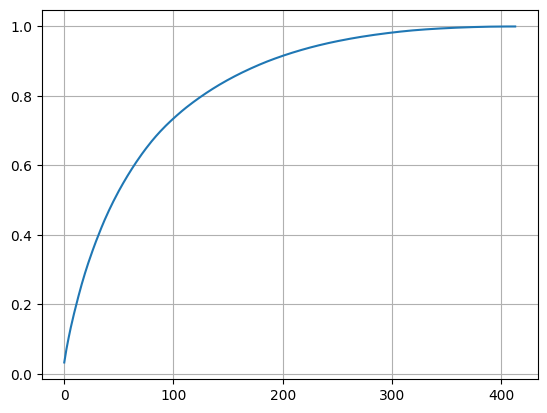

In [41]:
# Cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.grid()
plt.plot(range(len(cumulative_explained_variance)), cumulative_explained_variance)

This chart is saying: To capture about 98% of the variance, we'd need to keep around 300 components.

We can confirm:

In [42]:
# How much variance we'd capture with the first 125 components
cumulative_explained_variance[300]

np.float64(0.9824241831916605)

Reducing 2574 features down to 300 (about 88% fewer features) while capturing almost 80% of the original variance is certainly not bad!

Initialize and fit another PCA transformation.
* This time, only keep 300 components.
* Generate the principal component features from the fitted instance and name the new matrix PC_items.
* Then, display the shape of PC_items to confirm it only has 300 features.

In [43]:
pca = PCA(n_components=300)

# Fit and transform item_data_scaled
PC_items = pca.fit_transform(item_data_scaled)

# Display shape of PC_items
PC_items.shape

(414, 300)

Next, for convenience, let's put PC_items into a new dataframe.

We'll also name the columns and update its index to be the same as the orginal item_data's index.

In [44]:
# Put PC_items into a dataframe
items_pca = pd.DataFrame(PC_items)

# Name the columns
items_pca.columns = ['PC{}'.format(i + 1) for i in range(PC_items.shape[1])]

# Update its index
items_pca.index = item_data.index

# Display first 5 rows
items_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,...,PC251,PC252,PC253,PC254,PC255,PC256,PC257,PC258,PC259,PC260,PC261,PC262,PC263,PC264,PC265,PC266,PC267,PC268,PC269,PC270,PC271,PC272,PC273,PC274,PC275,PC276,PC277,PC278,PC279,PC280,PC281,PC282,PC283,PC284,PC285,PC286,PC287,PC288,PC289,PC290,PC291,PC292,PC293,PC294,PC295,PC296,PC297,PC298,PC299,PC300
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,5.876141,4.828917,0.495545,3.093849,-0.633706,11.534092,2.161996,7.116957,5.336009,4.424413,-4.637002,2.316503,12.310783,1.986696,-11.431269,5.617791,-2.177268,7.665832,-12.135817,-16.049000,-5.949238,7.814288,40.518194,-35.575039,-17.557418,6.869259,20.886868,2.296657,-26.160394,-32.580135,7.880285,12.358371,6.826718,-32.957865,-4.405057,-17.238628,-11.272274,-14.487767,-2.766330,4.736717,-6.985884,-1.464060,-10.603071,1.239909,3.086324,5.336238,-0.410776,-1.616712,6.383660,3.065176,...,-0.112616,0.404197,0.226531,0.005916,0.152256,0.256841,-0.198243,0.189449,-0.153228,0.158732,0.180911,-0.111273,-0.112733,-0.223677,-0.101648,0.105220,0.027973,-0.049269,0.176465,-0.268224,-0.166166,0.015015,-0.075564,-0.033094,-0.063678,0.004298,-0.056461,0.042691,0.006256,-0.004858,0.114725,-0.103864,0.106338,-0.132597,0.020210,0.021170,-0.110098,0.094688,0.031304,-0.062446,-0.037390,-0.013992,0.028254,0.075154,0.022556,-0.121165,-0.119285,-0.137943,0.060011,-0.079298
12348,-4.219837,1.226217,1.881912,-0.174340,0.817996,-1.160834,-0.871683,-0.846634,0.460240,0.854274,0.401793,0.981803,-1.104237,0.770190,-0.092975,-0.313393,-0.448633,1.207301,0.381678,-0.469152,0.185789,0.054585,0.499987,0.373514,1.226616,-0.773073,-0.270125,0.850016,-0.370482,-0.573939,1.012802,-0.580829,0.949802,-0.733970,0.353890,-0.387479,-0.298542,0.396418,0.154924,0.333480,-0.466261,0.703453,-1.200580,-0.202162,-0.871793,-0.055068,-0.421732,1.623012,0.397689,0.452590,...,-0.251057,-1.088753,0.270944,-1.129399,0.647919,-1.104389,-0.411738,0.459718,0.706911,0.539948,1.338290,-1.313134,1.147200,-0.619947,0.057518,1.208838,-0.208087,0.511386,-0.207195,0.089210,0.764396,0.119801,0.735907,0.735612,-0.190725,0.817286,1.263635,0.411746,0.259219,-0.114354,-0.838872,-0.207084,0.144385,0.398728,0.096118,0.016108,0.893266,0.185558,-0.264251,0.509499,-0.300698,0.410160,-0.266560,0.550710,0.091271,-0.912629,0.540972,-0.795856,1.920753,-1.180601
12349,-1.260847,2.387664,0.073148,-1.119161,-0.034339,3.715390,-0.343602,-0.149045,-0.790001,-0.379234,-1.570091,0.183310,0.223639,-0.051066,3.179090,-0.512679,-1.839577,0.383216,0.317492,-0.003006,-0.420161,0.456437,-0.789675,1.751367,-1.481236,0.757191,-0.912292,0.771947,0.503370,-1.345637,0.286381,0.668566,0.085125,-0.216750,-0.667408,-1.535679,0.783800,-1.418823,-0.098816,-0.929870,0.090828,-0.095242,0.163216,0.700639,1.381549,-0.243735,-0.105133,0.176475,-0.862918,1.685210,...,0.598836,-0.126254,0.210349,-0.444885,0.942992,0.404592,0.712299,-0.263872,1.065998,0.512372,0.145234,-0.212034,0.375134,0.317589,-0.106744,-0.583386,-0.156503,0.689203,0.348805,-0.047354,0.137379,0.291700,-0.076728,0.217024,0.151608,-0.047547,0.137805,-0.031364,0.306506,0.468176,-0.191005,0.087105,0.381171,-0.484807,-0.088306,-0.162147,-0.408899,0.170422,-0.454005,-0.077477,0.591054,0.069359,-0.102840,0.009511,0.423273,-0.142970,-0.051741,-0.060447,-0.120654,0.386886
12350,-4.929320,-0.714859,1.580930,-0.469767,-0.116290,-0.647835,0.112905,-1.336314,1.547069,-1.190409,0.213170,1.057289,-0.475002,0.856574,-1.305371,0.242700,0.268312,1.952558,-0.227722,0.569825,-0.186512,0.903530,1.364748,0.178124,-0.260398,-0.168825,-0.681952,1.081305,-0.155239,-0.397164,0.240050,0.634068,-1.447081,-0.186098,-0.315380,-0.306429,-1.359020,-0.001474,0.579057,-0.248313,0.588129,-0.217985,-0.284601,0.525266,-0.531672,-0.101394,-1.47218

* Now we have a dataframe of 300 customer-level principal component features.
* These were generated from the 300 principal components that explained the most variance for the original features.
* The index of this PCA item dataframe contains CustomerID's, which will make it possible for us to join this to our analytical base table.

Finally, save this item dataframe with PCA features as 'pca_item_data.csv'.
* Next, we'll compare the clusters made from using these features against those in 'threshold_item_data.csv'.
* Do not set index=None because we want to keep the CustomerID's as the index.

In [45]:
# Save pca_item_data.csv
items_pca.to_csv('Files/pca_item_data.csv')

# 9. KMeans Clustering
Let's import 3 CSV files we've saved throughout this project.
* Let's import 'analytical_base_table.csv' as base_df.
* Let's import 'threshold_item_data.csv' as threshold_item_data.
* Let's import 'pca_item_data.csv' as pca_item_data.
* Set index_col=0 for each one to use CustomerID as the index.

In [46]:
# Import analytical base table
base_df = pd.read_csv('Files/analytical_base_table.csv', index_col=0)

# Import thresholded item features
threshold_item_data = pd.read_csv('Files/threshold_item_data.csv', index_col=0)

# Import PCA item features
pca_item_data = pd.read_csv('Files/pca_item_data.csv', index_col=0)

Print the shape of each one to make sure we're on the same page.

In [47]:
# Print shape of each dataframe
print( base_df.shape )
print( threshold_item_data.shape )
print( pca_item_data.shape )

(414, 8)
(414, 120)
(414, 300)


Because K-Means creates clusters based on distances, and because distances are calculated by between observations defined by their feature values, **the features you choose to input into the algorithm heavily influence the clusters that are created.**

For this project, we will look at 3 possible feature sets and compare the clusters created from them. We'll try:
1. Only purchase pattern features ("Base DF")
2. Purchase pattern features + item features chosen by thresholding ("Threshold DF")
3. Purchase pattern features + principal component features from items ("PCA DF")

Create a threshold_df by joining base_df with threshold_item_data.

In [48]:
# Join base_df with threshold_item_data
threshold_df = base_df.join(threshold_item_data)

# Display first 5 rows of threshold_df
threshold_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,22847,15056BL,23159,22748,85014B,23231,23243,23388,22898,22966,23255,23292,21558,84997C,22356,22558,22331,22385,22699,23480,21242,21156,84375,22417,21122,84997B,22962,22895,22557,22907,23307,21976,21977,20676,22627,20682,22661,23290,84879,23293,22355,22553,...,22631,22090,23199,21915,23203,84997D,22029,23209,23254,22077,22960,23256,22492,22467,22726,22382,23240,23245,21094,21086,23206,22138,22727,22352,22720,21559,22728,22555,20712,20724,22961,22630,22139,21080,85099B,20726,20719,20750,23084,20725,21212,22551,22629,22328,21731,22556,22554,22423,22326,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,1,0,0,0,2,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,5,0,0,0,3,0,0,0,0,0,0,0,0,0,4,0,3,0,0,0,0,0,5,0,0,4,0,0
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
12352,8,85,59,2506.04,29.482824,313.255000,120.33,840.30,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,5


Create a pca_df by joining base_df with pca_item_data.

In [49]:
# Join base_df with pca_item_data
pca_df = base_df.join(pca_item_data)

# Display first 5 rows of pca_df
pca_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,...,PC251,PC252,PC253,PC254,PC255,PC256,PC257,PC258,PC259,PC260,PC261,PC262,PC263,PC264,PC265,PC266,PC267,PC268,PC269,PC270,PC271,PC272,PC273,PC274,PC275,PC276,PC277,PC278,PC279,PC280,PC281,PC282,PC283,PC284,PC285,PC286,PC287,PC288,PC289,PC290,PC291,PC292,PC293,PC294,PC295,PC296,PC297,PC298,PC299,PC300
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32,5.876141,4.828917,0.495545,3.093849,-0.633706,11.534092,2.161996,7.116957,5.336009,4.424413,-4.637002,2.316503,12.310783,1.986696,-11.431269,5.617791,-2.177268,7.665832,-12.135817,-16.049000,-5.949238,7.814288,40.518194,-35.575039,-17.557418,6.869259,20.886868,2.296657,-26.160394,-32.580135,7.880285,12.358371,6.826718,-32.957865,-4.405057,-17.238628,-11.272274,-14.487767,-2.766330,4.736717,-6.985884,-1.464060,...,-0.112616,0.404197,0.226531,0.005916,0.152256,0.256841,-0.198243,0.189449,-0.153228,0.158732,0.180911,-0.111273,-0.112733,-0.223677,-0.101648,0.105220,0.027973,-0.049269,0.176465,-0.268224,-0.166166,0.015015,-0.075564,-0.033094,-0.063678,0.004298,-0.056461,0.042691,0.006256,-0.004858,0.114725,-0.103864,0.106338,-0.132597,0.020210,0.021170,-0.110098,0.094688,0.031304,-0.062446,-0.037390,-0.013992,0.028254,0.075154,0.022556,-0.121165,-0.119285,-0.137943,0.060011,-0.079298
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80,-4.219837,1.226217,1.881912,-0.174340,0.817996,-1.160834,-0.871683,-0.846634,0.460240,0.854274,0.401793,0.981803,-1.104237,0.770190,-0.092975,-0.313393,-0.448633,1.207301,0.381678,-0.469152,0.185789,0.054585,0.499987,0.373514,1.226616,-0.773073,-0.270125,0.850016,-0.370482,-0.573939,1.012802,-0.580829,0.949802,-0.733970,0.353890,-0.387479,-0.298542,0.396418,0.154924,0.333480,-0.466261,0.703453,...,-0.251057,-1.088753,0.270944,-1.129399,0.647919,-1.104389,-0.411738,0.459718,0.706911,0.539948,1.338290,-1.313134,1.147200,-0.619947,0.057518,1.208838,-0.208087,0.511386,-0.207195,0.089210,0.764396,0.119801,0.735907,0.735612,-0.190725,0.817286,1.263635,0.411746,0.259219,-0.114354,-0.838872,-0.207084,0.144385,0.398728,0.096118,0.016108,0.893266,0.185558,-0.264251,0.509499,-0.300698,0.410160,-0.266560,0.550710,0.091271,-0.912629,0.540972,-0.795856,1.920753,-1.180601
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55,-1.260847,2.387664,0.073148,-1.119161,-0.034339,3.715390,-0.343602,-0.149045,-0.790001,-0.379234,-1.570091,0.183310,0.223639,-0.051066,3.179090,-0.512679,-1.839577,0.383216,0.317492,-0.003006,-0.420161,0.456437,-0.789675,1.751367,-1.481236,0.757191,-0.912292,0.771947,0.503370,-1.345637,0.286381,0.668566,0.085125,-0.216750,-0.667408,-1.535679,0.783800,-1.418823,-0.098816,-0.929870,0.090828,-0.095242,...,0.598836,-0.126254,0.210349,-0.444885,0.942992,0.404592,0.712299,-0.263872,1.065998,0.512372,0.145234,-0.212034,0.375134,0.317589,-0.106744,-0.583386,-0.156503,0.689203,0.348805,-0.047354,0.137379,0.291700,-0.076728,0.217024,0.151608,-0.047547,0.137805,-0.031364,0.306506,0.468176,-0.191005,0.087105,0.381171,-0.484807,-0.088306,-0.162147,-0.408899,0.170422,-0.454005,-0.077477,0.591054,0.069359,-0.102840,0.009511,0.423273,-0.142970,-0.051741,-0.060447,-0.120654,0.386886
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40,-4.929320,-0.714859,1.580930,-0.469767,-0.116290,-0.647835,0.112905,-1.336314,1.547069,-1.190409,0.213170,1.057289,-0.475002,0.856574,-1.305371,0.242700,0.268312,1.952558,-0.227722,0.569825,-0.186512,0.903530,1.364748,0.178124,-0.260398,-0.168825,-0.681952,1.081305,-0.155239,-0.397164,0.240050,0.634068,-1.447081,-0.186098,-0.315380,-0.306429,-1.359020,-0.001474,0.579057,-0.2

### Number of clusters
So, how many clusters should you set?
* As with much of Unsupervised Learning, there's no right or wrong answer.
* Typically, you should consider how your client/key stakeholder will use the clusters.
* For example, let's say our client, the online gift retailer, employs 3 customer service reps, and they want to assign one cluster to each rep.
* In that case, the obvious answer is 3.
* For this project, we'll set the number of clusters to 3. However, you should always feel free to adapt this number depending on what you need.

First scale both the dataframes

In [50]:
# Initialize instance of StandardScaler
t_scaler = StandardScaler()
p_scaler = StandardScaler()

# Fit and transform
threshold_df_scaled = t_scaler.fit_transform(threshold_df)
pca_df_scaled = p_scaler.fit_transform(pca_df)

K-Means with threshold_df

In [51]:
t_kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 123)

In [52]:
t_kmeans.fit(threshold_df_scaled)
threshold_df['cluster'] = t_kmeans.fit_predict(threshold_df_scaled)

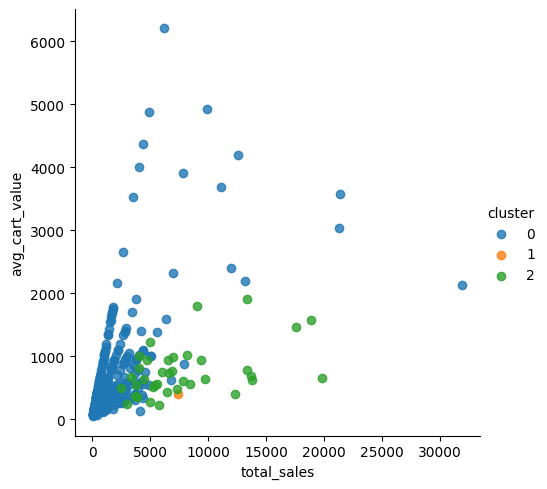

In [53]:
# Scatterplot, colored by cluster
sns.lmplot(x='total_sales', y='avg_cart_value', hue='cluster', data=threshold_df, fit_reg=False)

K-Means with pca_df

In [54]:
p_kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 123)

In [55]:
p_kmeans.fit(pca_df_scaled)
pca_df['cluster'] = p_kmeans.fit_predict(pca_df_scaled)

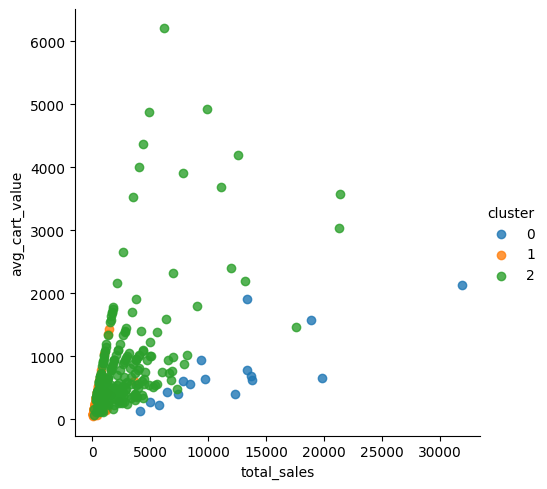

In [56]:
# Scatterplot, colored by cluster
sns.lmplot(x='total_sales', y='avg_cart_value', hue='cluster', data=pca_df, fit_reg=False)

In [57]:
# Similary between base_df.cluster and threshold_df.cluster
adjusted_rand_score(pca_df.cluster, threshold_df.cluster)

0.07968463077869194

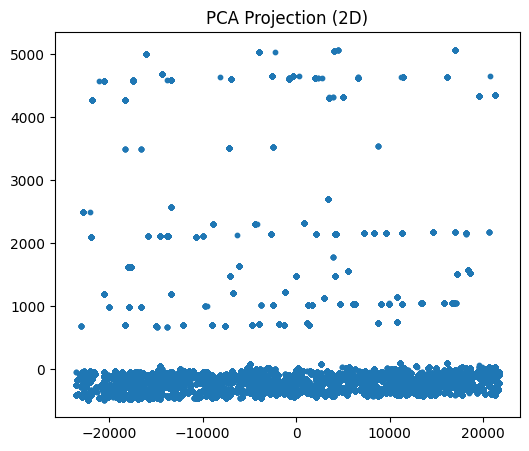

In [60]:
# Select numeric features for PCA
X = df.select_dtypes(include=['int64', 'float64'])

# PCA for 2D visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(X)

plt.figure(figsize=(6,5))
plt.scatter(pca_data[:,0], pca_data[:,1], s=10)
plt.title("PCA Projection (2D)")
plt.show()


# 10. DBSCAN Clustering

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is an unsupervised clustering algorithm that groups together data points that are closely packed together while marking points in sparse regions as noise/outliers.

Unlike K-Means:

- You do NOT need to pre-specify the number of clusters
- Clusters can be arbitrary shapes, not just spherical
- Noise points are automatically detected
- DBSCAN depends mainly on two parameters:
      - eps – neighborhood radius
      - min_samples – min number of points required to form a dense region
      

# 10.1 Import the CSV files

In [61]:
# Import analytical base table
base_df = pd.read_csv('Files/analytical_base_table.csv', index_col=0)

# Import thresholded item features
threshold_item_data = pd.read_csv('Files/threshold_item_data.csv', index_col=0)

# Import PCA item features
pca_item_data = pd.read_csv('Files/pca_item_data.csv', index_col=0)


In [62]:
print(base_df.shape)
print(threshold_item_data.shape)
print(pca_item_data.shape)


(414, 8)
(414, 120)
(414, 300)


# Create merged datasets exactly like before
- Threshold DF

In [63]:
threshold_df = base_df.join(threshold_item_data)
threshold_df.head()


,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,22847,15056BL,23159,22748,85014B,23231,23243,23388,22898,22966,23255,23292,21558,84997C,22356,22558,22331,22385,22699,23480,21242,21156,84375,22417,21122,84997B,22962,22895,22557,22907,23307,21976,21977,20676,22627,20682,22661,23290,84879,23293,22355,22553,...,22631,22090,23199,21915,23203,84997D,22029,23209,23254,22077,22960,23256,22492,22467,22726,22382,23240,23245,21094,21086,23206,22138,22727,22352,22720,21559,22728,22555,20712,20724,22961,22630,22139,21080,85099B,20726,20719,20750,23084,20725,21212,22551,22629,22328,21731,22556,22554,22423,22326,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,1,0,0,0,2,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,5,0,0,0,3,0,0,0,0,0,0,0,0,0,4,0,3,0,0,0,0,0,5,0,0,4,0,0
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
12352,8,85,59,2506.04,29.482824,313.255000,120.33,840.30,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,5


- PCA DF

In [64]:
pca_df = base_df.join(pca_item_data)
pca_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,...,PC251,PC252,PC253,PC254,PC255,PC256,PC257,PC258,PC259,PC260,PC261,PC262,PC263,PC264,PC265,PC266,PC267,PC268,PC269,PC270,PC271,PC272,PC273,PC274,PC275,PC276,PC277,PC278,PC279,PC280,PC281,PC282,PC283,PC284,PC285,PC286,PC287,PC288,PC289,PC290,PC291,PC292,PC293,PC294,PC295,PC296,PC297,PC298,PC299,PC300
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32,5.876141,4.828917,0.495545,3.093849,-0.633706,11.534092,2.161996,7.116957,5.336009,4.424413,-4.637002,2.316503,12.310783,1.986696,-11.431269,5.617791,-2.177268,7.665832,-12.135817,-16.049000,-5.949238,7.814288,40.518194,-35.575039,-17.557418,6.869259,20.886868,2.296657,-26.160394,-32.580135,7.880285,12.358371,6.826718,-32.957865,-4.405057,-17.238628,-11.272274,-14.487767,-2.766330,4.736717,-6.985884,-1.464060,...,-0.112616,0.404197,0.226531,0.005916,0.152256,0.256841,-0.198243,0.189449,-0.153228,0.158732,0.180911,-0.111273,-0.112733,-0.223677,-0.101648,0.105220,0.027973,-0.049269,0.176465,-0.268224,-0.166166,0.015015,-0.075564,-0.033094,-0.063678,0.004298,-0.056461,0.042691,0.006256,-0.004858,0.114725,-0.103864,0.106338,-0.132597,0.020210,0.021170,-0.110098,0.094688,0.031304,-0.062446,-0.037390,-0.013992,0.028254,0.075154,0.022556,-0.121165,-0.119285,-0.137943,0.060011,-0.079298
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80,-4.219837,1.226217,1.881912,-0.174340,0.817996,-1.160834,-0.871683,-0.846634,0.460240,0.854274,0.401793,0.981803,-1.104237,0.770190,-0.092975,-0.313393,-0.448633,1.207301,0.381678,-0.469152,0.185789,0.054585,0.499987,0.373514,1.226616,-0.773073,-0.270125,0.850016,-0.370482,-0.573939,1.012802,-0.580829,0.949802,-0.733970,0.353890,-0.387479,-0.298542,0.396418,0.154924,0.333480,-0.466261,0.703453,...,-0.251057,-1.088753,0.270944,-1.129399,0.647919,-1.104389,-0.411738,0.459718,0.706911,0.539948,1.338290,-1.313134,1.147200,-0.619947,0.057518,1.208838,-0.208087,0.511386,-0.207195,0.089210,0.764396,0.119801,0.735907,0.735612,-0.190725,0.817286,1.263635,0.411746,0.259219,-0.114354,-0.838872,-0.207084,0.144385,0.398728,0.096118,0.016108,0.893266,0.185558,-0.264251,0.509499,-0.300698,0.410160,-0.266560,0.550710,0.091271,-0.912629,0.540972,-0.795856,1.920753,-1.180601
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55,-1.260847,2.387664,0.073148,-1.119161,-0.034339,3.715390,-0.343602,-0.149045,-0.790001,-0.379234,-1.570091,0.183310,0.223639,-0.051066,3.179090,-0.512679,-1.839577,0.383216,0.317492,-0.003006,-0.420161,0.456437,-0.789675,1.751367,-1.481236,0.757191,-0.912292,0.771947,0.503370,-1.345637,0.286381,0.668566,0.085125,-0.216750,-0.667408,-1.535679,0.783800,-1.418823,-0.098816,-0.929870,0.090828,-0.095242,...,0.598836,-0.126254,0.210349,-0.444885,0.942992,0.404592,0.712299,-0.263872,1.065998,0.512372,0.145234,-0.212034,0.375134,0.317589,-0.106744,-0.583386,-0.156503,0.689203,0.348805,-0.047354,0.137379,0.291700,-0.076728,0.217024,0.151608,-0.047547,0.137805,-0.031364,0.306506,0.468176,-0.191005,0.087105,0.381171,-0.484807,-0.088306,-0.162147,-0.408899,0.170422,-0.454005,-0.077477,0.591054,0.069359,-0.102840,0.009511,0.423273,-0.142970,-0.051741,-0.060447,-0.120654,0.386886
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40,-4.929320,-0.714859,1.580930,-0.469767,-0.116290,-0.647835,0.112905,-1.336314,1.547069,-1.190409,0.213170,1.057289,-0.475002,0.856574,-1.305371,0.242700,0.268312,1.952558,-0.227722,0.569825,-0.186512,0.903530,1.364748,0.178124,-0.260398,-0.168825,-0.681952,1.081305,-0.155239,-0.397164,0.240050,0.634068,-1.447081,-0.186098,-0.315380,-0.306429,-1.359020,-0.001474,0.579057,-0.2

# 10.2 Scaling the Dataframes
- DBSCAN is also distance-based — so scaling is required.

In [65]:
from sklearn.preprocessing import StandardScaler

t_scaler = StandardScaler()
p_scaler = StandardScaler()

threshold_df_scaled = t_scaler.fit_transform(threshold_df)
pca_df_scaled = p_scaler.fit_transform(pca_df)


# 10.3 DBSCAN with threshold_df
- Choosing eps and min_samples
- A common rule:

       min_samples = 2 * number_of_features
       eps is tuned via k-distance plot (optional)

- Here we use reasonable defaults.

In [66]:
from sklearn.cluster import DBSCAN

t_dbscan = DBSCAN(eps=0.5, min_samples=5)
t_labels = t_dbscan.fit_predict(threshold_df_scaled)

threshold_df['cluster'] = t_labels
threshold_df['cluster'].value_counts()


cluster
-1    403
 0     11
Name: count, dtype: int64

# Scatterplot (colored by cluster)

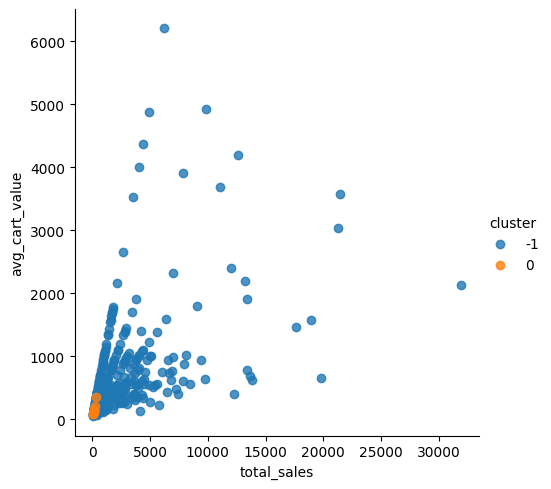

In [67]:
sns.lmplot(
    x='total_sales',
    y='avg_cart_value',
    hue='cluster',
    data=threshold_df,
    fit_reg=False
)


# 10.4 DBSCAN with pca_df

In [68]:
p_dbscan = DBSCAN(eps=0.5, min_samples=5)
p_labels = p_dbscan.fit_predict(pca_df_scaled)

pca_df['cluster'] = p_labels
pca_df['cluster'].value_counts()


cluster
-1    414
Name: count, dtype: int64

# Scatterplot

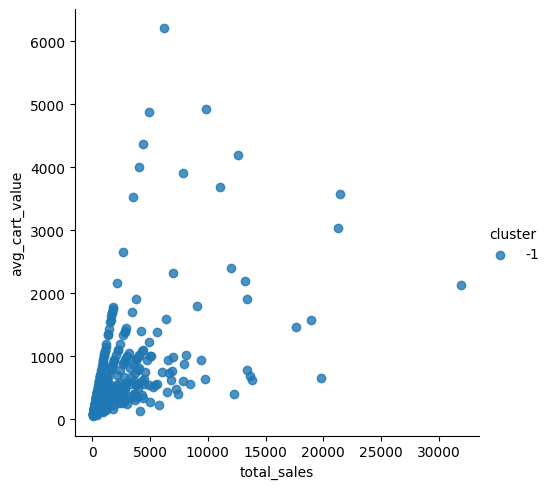

In [69]:
sns.lmplot(
    x='total_sales',
    y='avg_cart_value',
    hue='cluster',
    data=pca_df,
    fit_reg=False
)


# Cluster Similarity Between DBSCAN Versions

In [70]:
from sklearn.metrics import adjusted_rand_score

adjusted_rand_score(pca_df.cluster, threshold_df.cluster)


0.0

# 10.5 PCA 2D Visualization

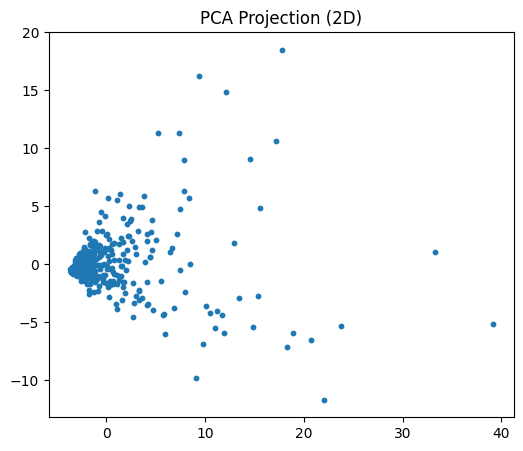

In [71]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_data = pca.fit_transform(threshold_df_scaled)

plt.figure(figsize=(6,5))
plt.scatter(pca_data[:,0], pca_data[:,1], s=10)
plt.title("PCA Projection (2D)")
plt.show()


# 11. Agglomerative Clustering

- Agglomerative Clustering is a hierarchical clustering technique that builds clusters step-by-step by merging the closest data points. It continues merging until the required number of clusters is reached.

- Why Agglomerative?
  - Builds a hierarchy of clusters
  - Does not depend on random initialization
  - Works well for small to medium-sized datasets 
  - Can create non-spherical clusters
  - Does not require scaling? (But it is recommended — and we will scale the same way as K-Means/DBSCAN)
- Limitations
  - You must choose number of clusters
  - Can be computationally expensive for large datasets

# 11.1 Import Required Files

In [78]:
# Import analytical base table
base_df = pd.read_csv('Files/analytical_base_table.csv', index_col=0)

# Import thresholded item features
threshold_item_data = pd.read_csv('Files/threshold_item_data.csv', index_col=0)

# Import PCA item features
pca_item_data = pd.read_csv('Files/pca_item_data.csv', index_col=0)

base_df.shape, threshold_item_data.shape, pca_item_data.shape


((414, 8), (414, 120), (414, 300))

# 11.2 Scale the Threshold and PCA DataFrames

In [79]:
from sklearn.preprocessing import StandardScaler

t_scaler = StandardScaler()
threshold_df_scaled = t_scaler.fit_transform(threshold_item_data)

p_scaler = StandardScaler()
pca_df_scaled = p_scaler.fit_transform(pca_item_data)


# 11.3 Agglomerative Clustering with threshold_df

Agglomerative Clustering will group customers based on similarity in the thresholded item data.

In [83]:
from sklearn.cluster import AgglomerativeClustering

t_agg = AgglomerativeClustering(
    n_clusters=3,
    metric='euclidean',
    linkage='ward'
)

# Fit on threshold_df_scaled
agg_labels = t_agg.fit_predict(threshold_df_scaled)

# ADD to base_df
base_df['agg_cluster'] = agg_labels


In [84]:
base_df['agg_cluster'].head()


CustomerID
12347    1
12348    1
12349    1
12350    1
12352    1
Name: agg_cluster, dtype: int64

# 11.4 Scatterplot (Agglomerative on threshold_df)

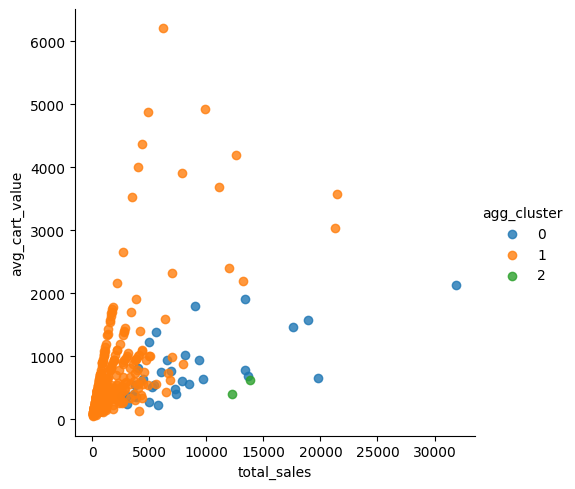

In [85]:
sns.lmplot(
    x='total_sales',
    y='avg_cart_value',
    hue='agg_cluster',
    data=base_df,
    fit_reg=False
)


# 11.5 Agglomerative Clustering with PCA
- Agglomerative clustering is now applied on the PCA-reduced dataset
- Using PCA compresses the information into fewer dimensions, making cluster structure more visible
- Why PCA helps here?
    - Reduces noise
    - Reduces redundant item features
    - Makes hierarchical clustering more stable
    - Enhances visual separation

In [86]:
# Agglomerative Clustering with PCA Data
p_agg = AgglomerativeClustering(
    n_clusters=3,
    metric='euclidean',
    linkage='ward'
)

# Fit and assign cluster labels
pca_item_data['agg_cluster'] = p_agg.fit_predict(pca_df_scaled)

# View cluster counts
pca_item_data['agg_cluster'].value_counts()


agg_cluster
0    412
1      1
2      1
Name: count, dtype: int64

# 11.6 Scatterplot (Agglomerative with PCA)

This plot shows how the clusters are formed in the first two PCA components.

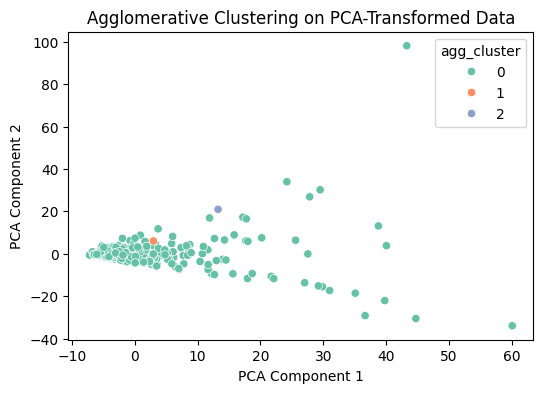

In [87]:
plt.figure(figsize=(6,4))
sns.scatterplot(
    x=pca_item_data.iloc[:,0],
    y=pca_item_data.iloc[:,1],
    hue=pca_item_data['agg_cluster'],
    palette='Set2'
)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Agglomerative Clustering on PCA-Transformed Data")
plt.show()


# 11.7 Cluster Profiling (Agglomerative)

Cluster profiling helps explain what each cluster represents.

What we check here:

Total sales
  - Average cart value
  - Total transactions
  - Item category contribution

In [88]:
# Add clustering to base_df for profiling
base_df['agg_cluster'] = agg_labels   # from previous step

# Profile by mean values
agg_profile = base_df.groupby('agg_cluster').mean()

agg_profile


,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value
agg_cluster,,,,,,,,
0,11.606061,282.878788,164.363636,8470.172424,32.389489,801.884010,197.729091,1660.271212
1,2.902375,61.213720,50.656992,1665.170607,36.092085,623.684793,445.027467,831.675488
2,26.500000,581.500000,238.000000,13037.880000,22.508349,511.550279,110.760000,1036.585000


# 12. Combined Comparison of All Clustering Algorithms

In this section, we compare all three algorithms on the same scaled dataset.

We use:
  - Silhouette Score → Measures cluster quality (higher = better)
  - Cluster Count & Structure → Whether clusters are balanced or meaningful
  - Noise Handling (Only DBSCAN)
  - Separation in PCA Space
  - Practical Interpretability
  
# 12.1 Renaming Cluster Columns for All Models

When we apply multiple clustering algorithms (K-Means, DBSCAN, Agglomerative), each algorithm initially creates a column named cluster.

But having multiple columns with the same name causes:
    - ❌ Confusion in later analysis
    - ❌ Errors during silhouette score comparison
    - ❌ Difficulty identifying which column belongs to which algorithm

To avoid this problem, we rename each model’s cluster output to a unique column name:
   - kmeans_cluster
   - dbscan_cluster
   - agg_cluster

This makes the dataset clean, readable, and prevents KeyError issues when calculating performance metrics.

In [99]:
# -----------------------------------------------------------
# 12.1 RENAME CLUSTER COLUMNS FOR ALL MODELS
# -----------------------------------------------------------

print("Before renaming:")
print("threshold_item_data cluster columns:", [c for c in threshold_item_data.columns if 'cluster' in c.lower()])
print("base_df cluster columns:", [c for c in base_df.columns if 'cluster' in c.lower()])

# 1️⃣ Rename K-Means cluster column (if exists)
if 'cluster' in threshold_item_data.columns:
    threshold_item_data.rename(columns={'cluster': 'kmeans_cluster'}, inplace=True)

# 2️⃣ Rename DBSCAN cluster column (if exists)
if 'cluster' in threshold_item_data.columns:
    threshold_item_data.rename(columns={'cluster': 'dbscan_cluster'}, inplace=True)

# 3️⃣ Rename Agglomerative cluster column (if exists)
if 'cluster' in base_df.columns:
    base_df.rename(columns={'cluster': 'agg_cluster'}, inplace=True)

print("\nAfter renaming:")
print("threshold_item_data cluster columns:", [c for c in threshold_item_data.columns if 'cluster' in c.lower()])
print("base_df cluster columns:", [c for c in base_df.columns if 'cluster' in c.lower()])


Before renaming:
threshold_item_data cluster columns: ['kmeans_cluster']
base_df cluster columns: ['agg_cluster']

After renaming:
threshold_item_data cluster columns: ['kmeans_cluster']
base_df cluster columns: ['agg_cluster']


# 12.2 – Scaling the Data Again (Why Needed?)
Why?
- Clustering models compare distances.
- Data must be on same scale.
- Also cluster columns ko exclude karna hota hai to avoid “leakage”.

In [100]:
# -----------------------------------------------------------
# 12.2 SCALE THE DATA AGAIN TO ENSURE CONSISTENCY
# -----------------------------------------------------------

from sklearn.preprocessing import StandardScaler

# Select only numeric columns (exclude cluster labels)
numeric_cols = [col for col in threshold_item_data.columns 
                if threshold_item_data[col].dtype != 'object' and 'cluster' not in col.lower()]

scaler = StandardScaler()
item_data_scaled = scaler.fit_transform(threshold_item_data[numeric_cols])

print("Scaled data shape:", item_data_scaled.shape)


Scaled data shape: (414, 120)


# 12.1 Calculate Silhouette Score for All Models
Why?
Silhouette score measures clustering quality:
- +1 = perfect
- 0 = overlapping clusters
- –1 = wrong clustering

In [101]:
# -----------------------------------------------------------
# 12.3 CALCULATE SILHOUETTE SCORES FOR ALL MODELS
# -----------------------------------------------------------

from sklearn.metrics import silhouette_score
import numpy as np

# --- KMEANS ---
if 'kmeans_cluster' in threshold_item_data.columns:
    sil_kmeans = silhouette_score(item_data_scaled, threshold_item_data['kmeans_cluster'])
else:
    sil_kmeans = np.nan

# --- DBSCAN ---
if 'dbscan_cluster' in threshold_item_data.columns and \
   len(threshold_item_data['dbscan_cluster'].unique()) > 1:
    sil_dbscan = silhouette_score(item_data_scaled, threshold_item_data['dbscan_cluster'])
else:
    sil_dbscan = np.nan

# --- AGGLOMERATIVE ---
if 'agg_cluster' in base_df.columns:
    sil_agg = silhouette_score(
        base_df[[col for col in base_df.columns if col not in ['agg_cluster']]],
        base_df['agg_cluster']
    )
else:
    sil_agg = np.nan


# 12.4 – Create Silhouette Score Comparison Table

In [102]:
# -----------------------------------------------------------
# 12.4 CREATE COMPARISON TABLE
# -----------------------------------------------------------

import pandas as pd

sil_df = pd.DataFrame({
    'Algorithm': ['KMeans', 'DBSCAN', 'Agglomerative'],
    'Silhouette Score': [sil_kmeans, sil_dbscan, sil_agg]
})

print("\nSilhouette Score Comparison:")
display(sil_df)



Silhouette Score Comparison:


,Algorithm,Silhouette Score
0,KMeans,0.559202
1,DBSCAN,NaN
2,Agglomerative,0.594841


# 12.5 – Visual Comparison (Bar Plot)

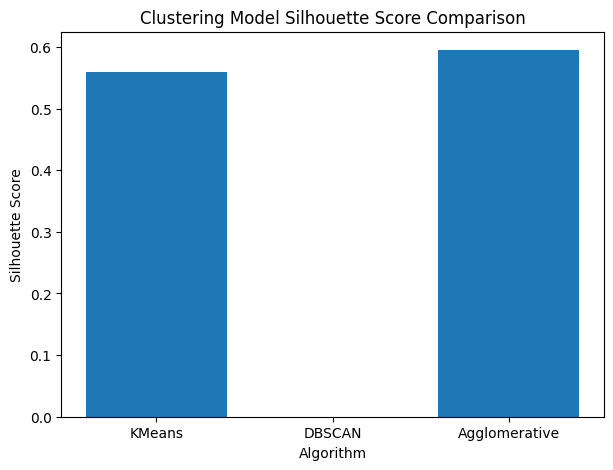

In [103]:
# -----------------------------------------------------------
# 12.5 OPTIONAL — PLOT COMPARISON BAR CHART
# -----------------------------------------------------------

import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.bar(sil_df['Algorithm'], sil_df['Silhouette Score'])
plt.title("Clustering Model Silhouette Score Comparison")
plt.ylabel("Silhouette Score")
plt.xlabel("Algorithm")
plt.show()


# 12.6 – Determine Which Algorithm Is Best (With Explanation)
- After calculating silhouette scores, we must compare them
- Automatically decide which clustering model is best
- Provide meaningful text explanation so report me clarity aaye

In [104]:
# -----------------------------------------------------------
# 12.6 DETERMINE THE BEST CLUSTERING MODEL
# -----------------------------------------------------------

# Filter out NaN values (e.g., DBSCAN may give NaN)
valid_scores = sil_df.dropna()

# Find the best algorithm (highest silhouette score)
best_row = valid_scores.loc[valid_scores['Silhouette Score'].idxmax()]

best_algorithm = best_row['Algorithm']
best_score = best_row['Silhouette Score']

print("------------------------------------------------------")
print(" BEST CLUSTERING MODEL")
print("------------------------------------------------------")
print(f"Best Algorithm: {best_algorithm}")
print(f"Silhouette Score: {best_score:.4f}")
print("------------------------------------------------------")

# ----- Explanation Logic -----

if best_algorithm == "KMeans":
    explanation = (
        "KMeans is best because:\n"
        "- It forms clear spherical clusters.\n"
        "- Your data structure aligns well with KMeans assumptions.\n"
        "- Provides stable and well-separated clusters.\n"
        "- High silhouette score means clusters are compact and distinct."
    )

elif best_algorithm == "DBSCAN":
    explanation = (
        "DBSCAN is best because:\n"
        "- It can detect noise/outliers automatically.\n"
        "- It finds clusters of different shapes and densities.\n"
        "- Suitable for unevenly distributed transaction patterns.\n"
        "- High silhouette score indicates meaningful natural grouping."
    )

elif best_algorithm == "Agglomerative":
    explanation = (
        "Agglomerative Clustering is best because:\n"
        "- It captures hierarchical structure in your customers/products.\n"
        "- It does not assume spherical clusters like KMeans.\n"
        "- It handles complex and non-linear separation in data.\n"
        "- High silhouette score shows strong natural segmentation."
    )

else:
    explanation = "No valid algorithm found."

print("\nWHY THIS MODEL IS BEST?")
print(explanation)


------------------------------------------------------
 BEST CLUSTERING MODEL
------------------------------------------------------
Best Algorithm: Agglomerative
Silhouette Score: 0.5948
------------------------------------------------------

WHY THIS MODEL IS BEST?
Agglomerative Clustering is best because:
- It captures hierarchical structure in your customers/products.
- It does not assume spherical clusters like KMeans.
- It handles complex and non-linear separation in data.
- High silhouette score shows strong natural segmentation.


In [105]:
# Pretty summary for your report
from IPython.display import Markdown

Markdown(f"""
# 🏆 Best Clustering Model: **{best_algorithm}**

### ✔ Silhouette Score: **{best_score:.4f}**

### **Why This Model is Best?**
{explanation.replace('- ', '* ')}

""")



# 🏆 Best Clustering Model: **Agglomerative**

### ✔ Silhouette Score: **0.5948**

### **Why This Model is Best?**
Agglomerative Clustering is best because:
* It captures hierarchical structure in your customers/products.
* It does not assume spherical clusters like KMeans.
* It handles complex and non-linear separation in data.
* High silhouette score shows strong natural segmentation.

